In [5]:
import torch


def print_config(config):
    attrs = {}
    attrs.update(config.__dict__)

    for key, value in config.__class__.__dict__.items():
        if not key.startswith('__') and key not in attrs:
            attrs[key] = value

    for key, value in attrs.items():
        print(f"{key}: {value}")


class Config:
    # Model
    model_name = "tabnet.100ep.wd.1e3.150ep.dy.mean.std.fixed.test"
    input_dim = 6
    target_dim = 1

    # Device & reproducibility
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seed = 5274

    # Optimization
    optimizer_name = "AdamW"
    lr = 1e-4
    weight_decay = 1e-3

    grad_accum = False
    grad_accum_steps = 1
    batch_size = 32  # // grad_accum_steps

    # Training schedule
    num_epochs = 150
    scheduler_name = "default"

    # Regularization
    dropout = 0.0
    drop_path_rate = 0.0
    label_smoothing = 0.0

    # Experiment tracking
    neptune_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlOGE2YjNiZS1mZGUyLTRjYjItYTg5Yy1mZWJkZTIzNzE1NmIifQ=="
    with_id = ""
    resume = False

config = Config()

In [6]:
import random
import numpy as np
import torch

def setup_reproducibility(config):
    random.seed(config.seed)
    np.random.seed(config.seed)
    torch.manual_seed(config.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(config.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False, warn_only=True)
    torch.set_float32_matmul_precision("high")

setup_reproducibility(config)

In [9]:
import pandas as pd

path = "/Users/arbaaz/Downloads/air-pol/ds"
train_path = path+"/train.csv"
df = pd.read_csv(train_path).drop(columns=['id'])
df.dropna(inplace=True)

test = pd.read_csv(path+"/test.csv").drop(columns=['id'])
pol = [0 for i in range(len(test))]
test["pollution_value"] = pol

In [10]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(
    df,
    train_size=0.8, 
    random_state=config.seed, 
    shuffle=False
)

In [8]:
df.head()

,latitude,longitude,day_of_year,day_of_week,hour,month,pollution_value
0,51.491,-0.172,301,6,3,10,14.5
1,39.386,-121.158,254,3,21,9,34.5
2,51.459,0.596,301,6,3,10,10.5
3,35.299,-120.613,145,2,14,5,15.5
4,29.927,120.527,221,0,14,8,54.5


In [62]:
len(df), len(train), len(val)

(7636, 6108, 1528)

In [63]:
for col in df.columns:
    arr1 = df[col].to_numpy()
    arr2 = train[col].to_numpy()
    arr3 = val[col].to_numpy()
    arr4 = test[col].to_numpy()

    print(col, arr1.mean(), arr2.mean(), arr3.mean(), arr4.mean())
    print(col, arr1.std(), arr2.std(), arr3.std(), arr4.std())
    print()

latitude 31.88018046097433 31.927353143418465 31.69161321989529 36.77157758305951
latitude 17.797338101721373 17.75012337455518 17.983599523954226 23.560494059427153

longitude 32.10077737035097 31.10515798952194 36.080648560209426 25.15620554947061
longitude 97.80538152515152 97.9070195004782 97.29632915872659 72.7445052726327

day_of_year 203.5284180199057 203.01571709233792 205.57787958115182 28.414384811975175
day_of_year 79.91583350238251 80.1982139360122 78.74360579180666 5.724305998721437

day_of_week 1.5610267155578836 1.553372626064178 1.5916230366492146 3.203358890105878
day_of_week 1.7935832876571327 1.7915979650815805 1.8011726791738478 1.3706527545023874

hour 11.0637768465165 11.025049115913555 11.218586387434556 10.921504198612633
hour 6.238451254431803 6.273471545591326 6.093994992207517 3.2011842575613487

month 7.106338397066527 7.088736083824492 7.1767015706806285 1.000365096750639
month 2.6327423480146317 2.6423427645354014 2.592817628852766 0.01910401672428058

pol

In [64]:
import matplotlib.pyplot as plt

def plot_geographic_distribution(df, lat_col='latitude', lon_col='longitude', title='Geographic Distribution of Jittered Coordinates'):
    """
    Plots a scatter plot of geographic coordinates.

    Parameters:
    - df: pd.DataFrame containing latitude and longitude columns
    - lat_col: str, name of the latitude column
    - lon_col: str, name of the longitude column
    - title: str, title of the plot
    """
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Scatter plot of points with a bit of transparency
    ax.scatter(df[lon_col], df[lat_col], s=20, alpha=0.6)
    
    # Set axis labels
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    # Set a title
    ax.set_title(title, fontsize=14)
    
    # Ensure equal aspect ratio so lat/long scales are comparable
    ax.set_aspect('equal', 'box')
    
    # Enhance layout
    plt.tight_layout()
    plt.show()


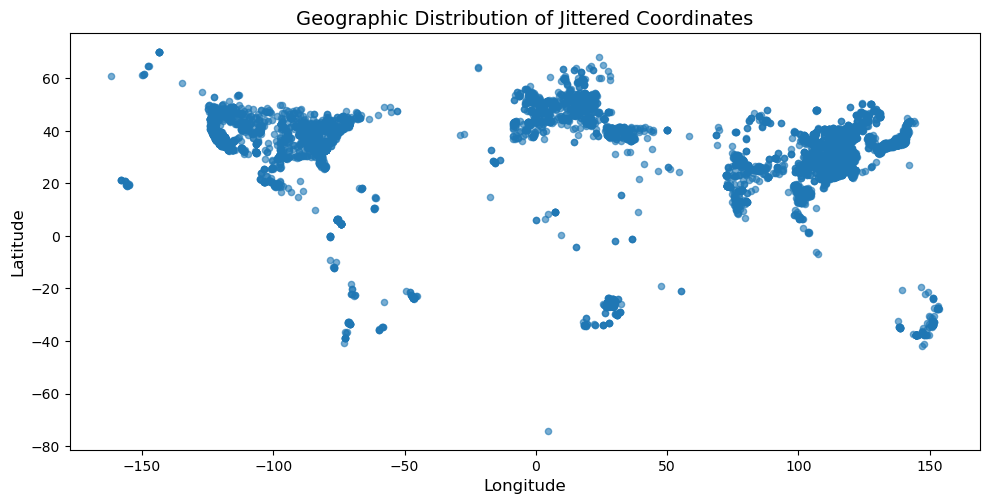

In [65]:
plot_geographic_distribution(df)

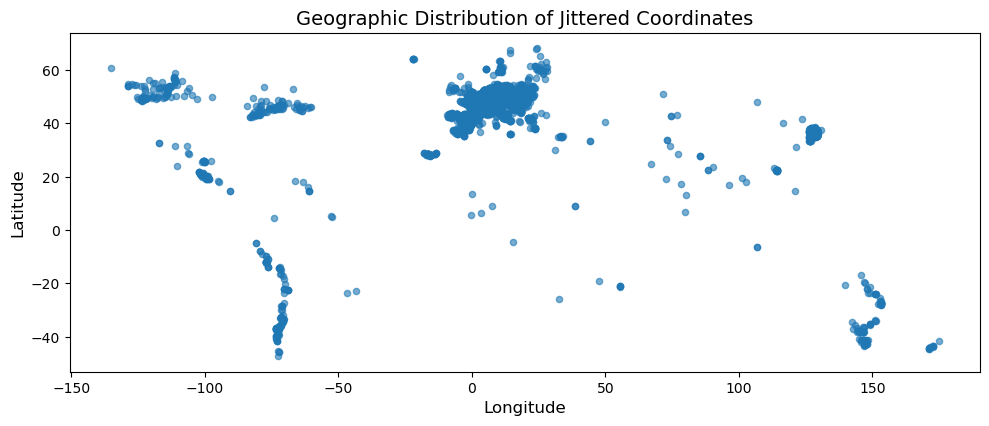

In [69]:
plot_geographic_distribution(test)

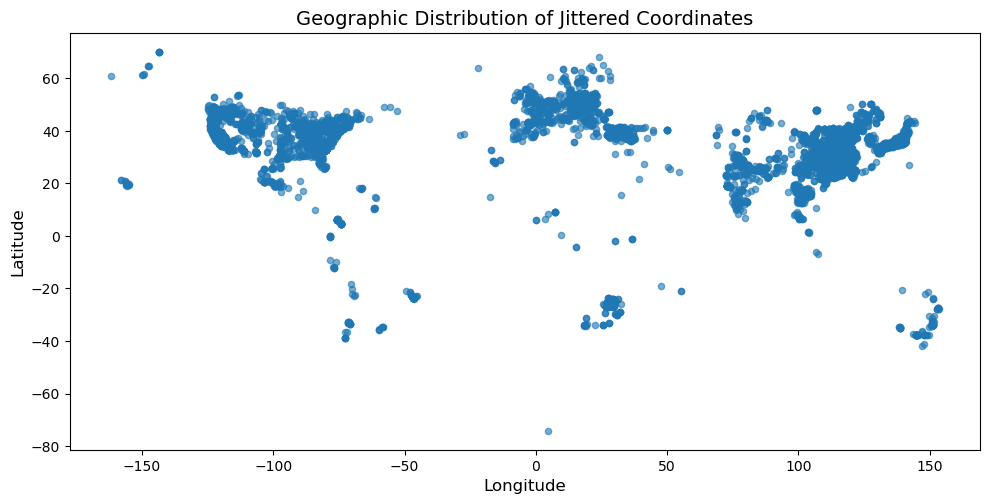

In [66]:
plot_geographic_distribution(train)

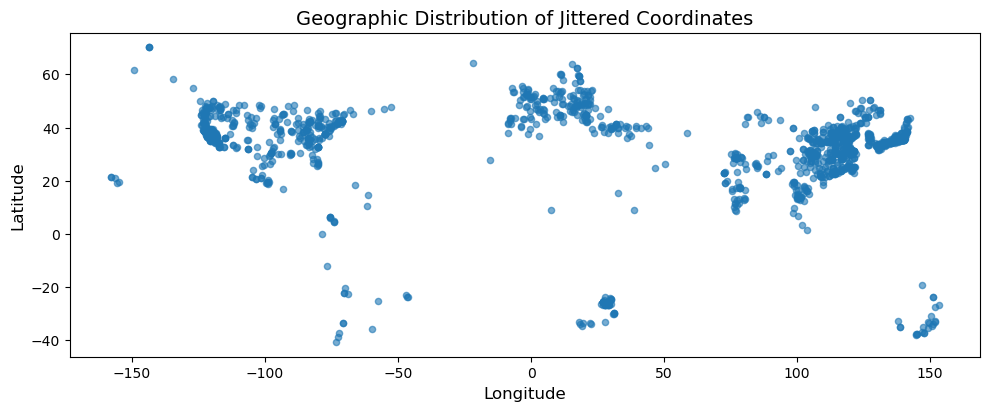

In [67]:
plot_geographic_distribution(val)

In [84]:
df.columns

Index(['latitude', 'longitude', 'day_of_year', 'day_of_week', 'hour', 'month',
       'pollution_value'],
      dtype='object')

In [87]:
for col in df.columns:
    for set in [df, test]:
        print(set[col].value_counts())
        print()
    print()

latitude
 32.839    39
 38.940    35
 37.597    35
 41.516    27
-25.587    23
           ..
 37.288     1
 37.111     1
 52.355     1
 46.233     1
 35.504     1
Name: count, Length: 6102, dtype: int64

latitude
 50.927    4
 37.397    4
 50.793    3
 50.638    3
 51.558    3
          ..
 46.868    1
 42.473    1
-40.597    1
 50.913    1
-27.357    1
Name: count, Length: 2537, dtype: int64


longitude
-80.001     39
-77.451     35
-119.938    34
-96.178     27
 27.098     23
            ..
 113.623     1
-104.131     1
 100.235     1
 113.920     1
-83.297      1
Name: count, Length: 6628, dtype: int64

longitude
 126.748    4
 126.986    3
 127.085    3
 23.814     3
 127.075    3
           ..
-73.193     1
 6.019      1
 0.338      1
-0.316      1
 127.030    1
Name: count, Length: 2600, dtype: int64


day_of_year
221    1597
267    1056
151     997
150     248
304     207
       ... 
17        1
293       1
310       1
209       1
321       1
Name: count, Length: 359, dtype: int

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_pollution_relation(df: pd.DataFrame, col: str):
    """
    Displays the relationship between 'pollution_value' and another column.
    Special handling if 'latitude' or 'longitude' is provided: plots both coordinates.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'pollution_value' and the target column.
        col (str): Column name to relate against 'pollution_value'.
    """
    # Validate inputs
    if 'pollution_value' not in df.columns:
        raise ValueError("DataFrame must contain a 'pollution_value' column.")
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in DataFrame.")
    
    # If either latitude or longitude is specified, plot geo-scatter
    if col in ('latitude', 'longitude'):
        if 'latitude' not in df.columns or 'longitude' not in df.columns:
            raise ValueError("Both 'latitude' and 'longitude' must be in DataFrame for geo-plot.")
        fig, ax = plt.subplots(figsize=(10, 6))
        sc = ax.scatter(df['longitude'], df['latitude'], 
                        c=df['pollution_value'], cmap='viridis', s=30, alpha=0.7)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Pollution vs. Geographic Location')
        plt.colorbar(sc, label='Pollution Value')
    
    else:
        # Determine if the column is categorical or continuous
        unique_vals = df[col].nunique(dropna=True)
        if pd.api.types.is_numeric_dtype(df[col]) and unique_vals > 15:
            # Continuous numeric: scatter plot
            fig, ax = plt.subplots(figsize=(8, 5))
            ax.scatter(df[col], df['pollution_value'], s=20, alpha=0.6)
            ax.set_xlabel(col)
            ax.set_ylabel('Pollution Value')
            ax.set_title(f'Pollution vs. {col}')
        else:
            # Categorical or few unique values: bar plot of mean pollution
            summary = df.groupby(col)['pollution_value'].mean().sort_index()
            fig, ax = plt.subplots(figsize=(8, 5))
            summary.plot(kind='bar', ax=ax)
            ax.set_xlabel(col)
            ax.set_ylabel('Average Pollution Value')
            ax.set_title(f'Average Pollution by {col}')
            plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()


# plot_pollution_relation(df, 'month')
# plot_pollution_relation(df, 'latitude')


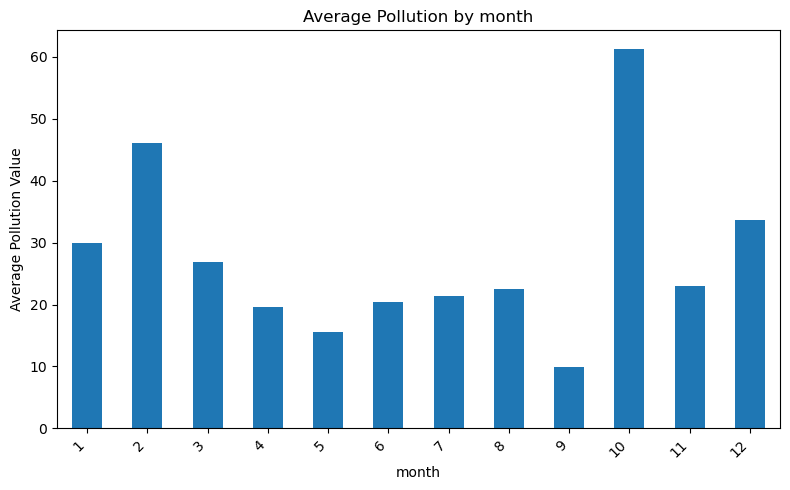

In [15]:
plot_pollution_relation(df, "month")

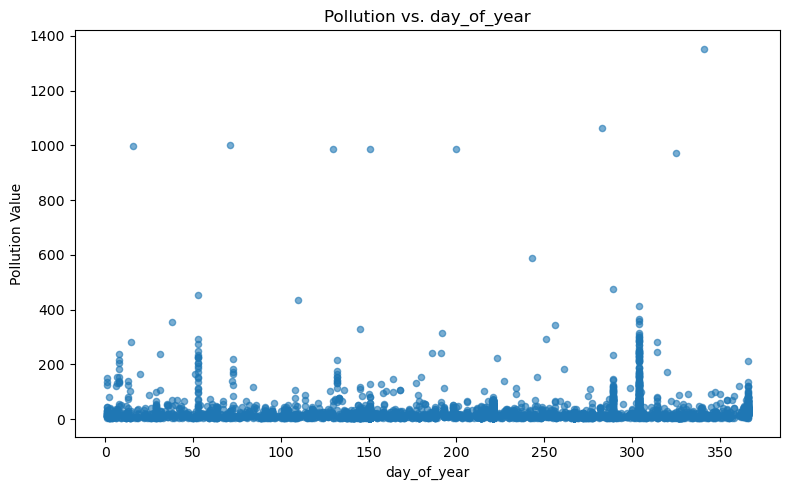

In [17]:
plot_pollution_relation(df, "day_of_year")

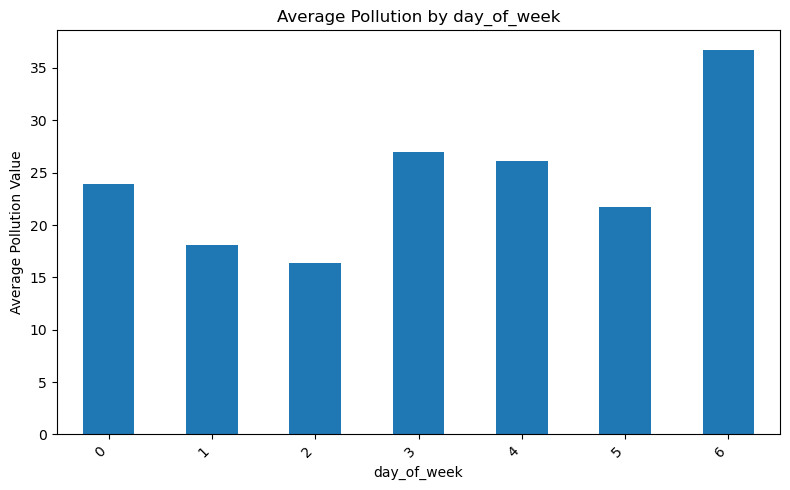

In [18]:
plot_pollution_relation(df, "day_of_week")

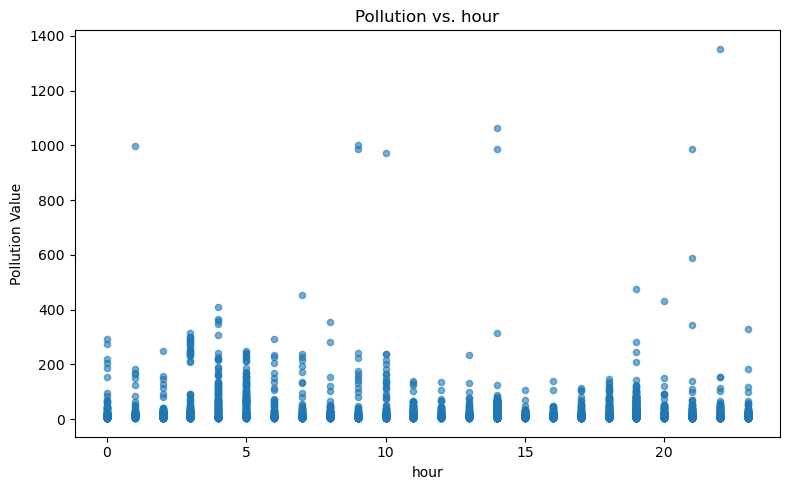

In [20]:
plot_pollution_relation(df, "hour")

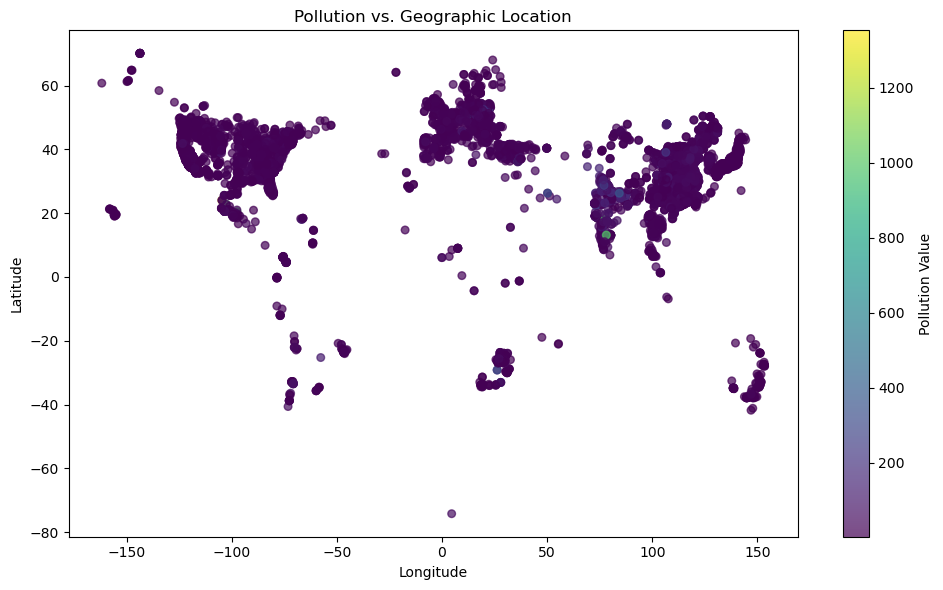

In [21]:
plot_pollution_relation(df, "latitude")

In [27]:
january_days = df[df['month'] == 1]['day_of_year']
print(january_days)

11      29
47      29
49      23
110     19
271     29
        ..
7522    30
7553    29
7566     1
7588    29
7598     3
Name: day_of_year, Length: 334, dtype: int64


In [30]:
january_days.value_counts()

day_of_year
29    149
1      25
2      13
8      12
4      12
13      9
12      9
6       9
3       9
31      8
9       6
22      6
18      6
30      6
14      6
26      5
7       5
23      5
15      5
19      4
5       4
11      4
24      3
28      3
25      3
16      2
10      2
27      1
21      1
20      1
17      1
Name: count, dtype: int64